In [ ]:
# Install efficientnet
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.1 MB/s eta 0:00:00


In [ ]:
# General imports
import pandas as pd
import numpy as np
import os
from shutil import rmtree
from shutil import copyfile
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import image as mpimg

# Model imports
import efficientnet.keras as efn
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

# Evaluation imports
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [ ]:
# Mount to gdrive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Store images in new directory
os.makedirs('images/NORMAL', exist_ok=True)
os.makedirs('images/PNEUMONIA', exist_ok=True)

base_path = '/content/drive/My Drive/xray_pneumonia_train'

for path in ['/train']:
  for dirname, _, filenames in os.walk(base_path+path):
      for i, file in enumerate(filenames):
          img_class = dirname.split('/')[6]
          copyfile(os.path.join(dirname, file), 'images/' + img_class + '/' + file)

In [ ]:
# Print image count
for dirname, _, filenames in os.walk('images'):
    if(len(dirname.split("/")) > 1):
        print(dirname + " has " + str(len(filenames)) + " files")

images/PNEUMONIA has 3888 files
images/NORMAL has 1349 files


In [ ]:
# Split train, test and validation in new directory

## rmtree('train') # remove existing, if re-run
## rmtree('test') # remove existing, if re-run

os.makedirs('model-train/NORMAL', exist_ok=True)
os.makedirs('model-train/PNEUMONIA', exist_ok=True)
os.makedirs('model-test/NORMAL', exist_ok=True)
os.makedirs('model-test/PNEUMONIA', exist_ok=True)

## Split NORMAL
train, test = train_test_split(os.listdir('images/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('model-train/NORMAL/', img))
for img in test:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('model-test/NORMAL/', img))

## Split PNEUMONIA
train, test = train_test_split(os.listdir('images/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('model-train/PNEUMONIA/', img))
for img in test:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('model-test/PNEUMONIA/', img))

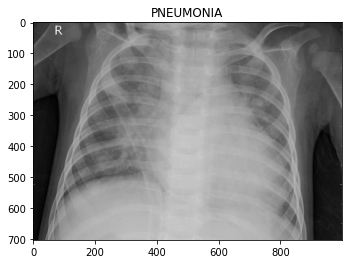

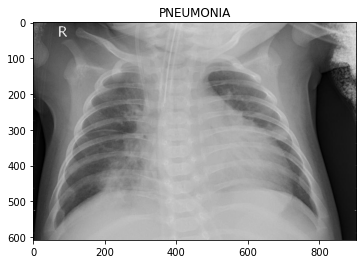

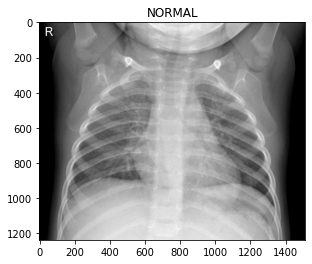

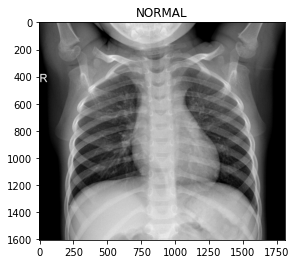

In [ ]:
# Print a few images to check if images are loaded correctly

for dirname, _, filenames in os.walk('model-train'):
    for i, file in enumerate(filenames):
        if(i > 1):
            break
        plt.imshow(mpimg.imread(os.path.join(dirname, file)), cmap='gray')
        plt.title(dirname.split('/')[1])
        plt.show()

In [ ]:
# Augment images for training
SIZE = 128
BATCH = 64

## Image augmentations
image_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                validation_split=0.2)

## flow_from_directory generators
train_generator = image_gen\
    .flow_from_directory('model-train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='training')

validation_generator = image_gen\
    .flow_from_directory('model-train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='validation')

Found 3352 images belonging to 2 classes.
Found 837 images belonging to 2 classes.


In [ ]:
# Callbacks
## Keep the best model
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)

In [ ]:
# Model
## Define the base model with EfficientNet weights
model = efn.EfficientNetB4(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (SIZE, SIZE, 3))

## Freeze the pretrained weights
model.trainable = False

## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=15,
                            verbose=1,
                            callbacks=[mc, rlr])

Epoch 1/15
52/52 [==============================] - 81s 1s/step - loss: 0.2763 - accuracy: 0.8851 - recall: 0.9345 - precision: 0.9128 - val_loss: 0.1583 - val_accuracy: 0.9427 - val_recall: 0.9630 - val_precision: 0.9599 - lr: 0.0010
Epoch 2/15
52/52 [==============================] - 58s 1s/step - loss: 0.1969 - accuracy: 0.9171 - recall: 0.9473 - precision: 0.9413 - val_loss: 0.1477 - val_accuracy: 0.9486 - val_recall: 0.9678 - val_precision: 0.9632 - lr: 0.0010
Epoch 3/15
52/52 [==============================] - 56s 1s/step - loss: 0.1779 - accuracy: 0.9308 - recall: 0.9542 - precision: 0.9526 - val_loss: 0.1143 - val_accuracy: 0.9606 - val_recall: 0.9775 - val_precision: 0.9697 - lr: 0.0010
Epoch 4/15
52/52 [==============================] - 55s 1s/step - loss: 0.1599 - accuracy: 0.9362 - recall: 0.9574 - precision: 0.9566 - val_loss: 0.1397 - val_accuracy: 0.9391 - val_recall: 0.9373 - val_precision: 0.9798 - lr: 0.0010
Epoch 5/15
52/52 [==============================] - 55s 1s/s

<Figure size 432x288 with 0 Axes>

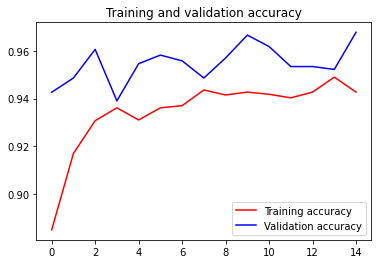

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training and validation accuracy by epoch
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
# Augment images for testing
test_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory(
    directory="model-test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

Found 1048 images belonging to 2 classes.


In [ ]:
# Obtain model predictions
preds = model.predict_generator(generator=test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes

<ipython-input-17-26894cbf5741>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(generator=test_generator) # get proba predictions


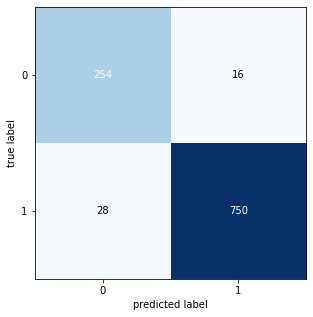

In [ ]:
# Plot Confusion matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
# Evaluate model
## Calculate the precision
precision = precision_score(test_generator.classes, labels)
print("Precision: ", precision)

## Calculate the recall
recall = recall_score(test_generator.classes, labels)
print("Recall: ", recall)

## Calculate the accuracy
accuracy = accuracy_score(test_generator.classes, labels)
print("Accuracy: ", accuracy)

## Calculate the F1-score
f1 = f1_score(test_generator.classes, labels)
print("F1-score: ", f1)

Precision:  0.97911227154047
Recall:  0.9640102827763496
Accuracy:  0.9580152671755725
F1-score:  0.971502590673575
